# Extract Sound Effects

We're going to extract the sound effects from a gameplay session and convert them to `wav` files. This will allow us to create fancy visualizations of the sound effects.

Going to do this by tracing all writes to `D401 - D415` and storing them in a log file. These are the Vice monitor commands for doing this:
```
log on                               
logname "IridisAlphaSoundEffects.txt"
tr store 79ac 79af                   
tr store 0030 0031                   
tr store d400 d40f                   
tr store d410 d418                   
command 1 "mem 79ac 79af"            
command 2 "mem 0030 0031"            
command 3 "mem d400 d40f"            
command 4 "mem d410 d418"            
```
Which we can run as (with the above in `soundeffects.txt`):
```
~/Dev/vice-emu-code/vice/src/x64sc -directory ~/Dev/vice-emu-code/vice/data/ -moncommands soundeffects.txt bin/iridisalpha.prg
```
We'll then extract the notes as they are written to the log file.

To help identify the sound effects, read in the listing from the assembled program. We can use this to identify which effect is playing.

In [216]:
from collections import defaultdict
log_file = "../iridisalpha/bin/list-ia.txt"
input_file = open(log_file,'r')

ia_data = defaultdict(str)
line_types = {".":"code",">":"data"}
prev_data_name = ""
for line in input_file.readlines():
    sentinel = line[0]
    if sentinel not in line_types:
        continue
    fields = line.split('\t')
    if len(fields) < 5:
        continue
    addr = fields[0][1:]
    if line_types[sentinel] == "data":
        data_source = ' '.join(fields[3:]).split()[-1]
        data_name = ' '.join(fields[3:]).split()[0].strip()
        if not data_name or data_name[0] in ["f","."] or data_name.startswith("setVol"):
            data_name = prev_data_name
        else:
            prev_data_name = data_name
        #trailing = trailing.replace('.BYTE','')
        ia_data[addr] = (data_name, data_source)
        continue
    ia_data[addr] = (fields[1],fields[2].strip(), fields[3].strip())
        


Read in our log file. We create a list called `sequences` that contains the state each time a value in the SID register (between D400 and D418) is written to. This state includes the name of the effect, which sound record is being played, the full state of the registers, as well as the value being written to which register this time

In [217]:
log_file = "IridisAlphaSoundEffects.txt"
input_file = open(log_file,'r')
lines = input_file.readlines()
sequences, curr_sequence, curr_effect = [], [], ['','']
prev_ind, primary, secondary = "","",""
curr_sid, curr_sid1, curr_sid2 = [],[],[]
clock = 0

for i in range(8, len(lines), 4):
    addr = lines[i][16:20]
    A = lines[i+1][40:42]
    
    if addr == "0030":
        if curr_sequence:
            sequences += [curr_sequence]
            curr_sequence = []
        curr_effect[1] = A
        continue
    if addr == "0031":
        curr_effect[0] = A
        data_addr = ''.join(curr_effect).lower()
        
        ind = prev_ind
        if data_addr == primary:
            ind = "primary"
        elif data_addr == secondary:
            ind = "secondary"
        prev_ind = ind
        
        curr_sequence += [ind, data_addr, primary, secondary, ia_data[data_addr]]
        continue
    
    if addr[:3] == "79a":
        primary = lines[i+3][12:14] + lines[i+3][9:11]
        secondary = lines[i+3][18:20] + lines[i+3][15:17]
        continue
    
    if addr[:3] == "d40":
        curr_sid1 = lines[i+3][9:59].strip().split()
    if addr[:3] == "d41":
        curr_sid2 = lines[i+3][9:59].strip().split()
        
    prev_clock = clock
    clock = int(lines[i+1][69:].strip())
    elapsed = clock - prev_clock

    curr_sid = curr_sid1 + curr_sid2
    curr_sequence += [(addr,A, curr_sid, elapsed)]

Extract just the items from `sequences` that we're interested in. This is whether it's the primary/secondary sound effect, the name of the effect, the register being written to, and the number of clock cycles elapsed since the last write.

In [218]:
samples = []
for s in sequences[5:]:
    if len(s) < 6:
        continue
    samples += [(s[0], s[4][0], s[5][0], s[5][1], s[5][3])]

In [120]:
samples[6]

('secondary', 'planetWarpSoundEffect', 'd418', '0F', 161)

## Create WAV Files

Rewrite the information for our effect in the Vice sound dump format (e.g. format created when running `x64sc -sounddev dump`. We can then use the `desidulate` library to turn this into a `wav` file.

In [219]:
from IPython.display import Audio

from desidulate.fileio import wav_path                      
from desidulate.sidlib import get_sid, reg2state, timer_args
from desidulate.sidwav import state2samples, write_wav      
pal = True
cia = True
samplerate = 22050
maxstates = int(10 * 1e6)

def createWav(effect):
    # Generate a file in Vice's SID register log format
    log_file = f'sound_effects/{effect}.dump'
    wav_file = f'sound_effects/{effect}.wav'
    w = open(log_file,'w')
    w.write(f"0 24 15\n") # Ensure vol set to max
    for t in [s for s in samples if s[1] == effect]:
        w.write(f"{t[4]} {int(t[2][-2:], 16)} {int(t[3],16)}\n")
    w.close()

    sid = get_sid(pal, cia, sampling_frequency=samplerate)
    df = reg2state(log_file, nrows=int(maxstates))
    raw_samples = state2samples(df, sid)
    write_wav(wav_file, sid, raw_samples)
    return (wav_file, df, raw_samples)

wav_files = []
effects = list(set([s[1] for s in samples]))
for effect in effects:
    wav_file,_,_ = createWav(effect)
    wav_files += [wav_file]


## Create a table of the planetWarpSoundEffect in action

In [203]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

fn,df,rs = createWav("planetWarpSoundEffect")

st = df[["freq2","gate2","saw2","dec2",
         "freq3","gate3","saw3","dec3","vol"]][1:28]
raw_samples = [f"\icode{{{s[4][1]}}}" for s in sequences[5:]
               if len(s) > 5 and s[4][0] == "planetWarpSoundEffect"]
data_records = raw_samples[1:28]
st["Data"] = data_records
st = st.set_index("Data")
st

,freq2,gate2,saw2,dec2,freq3,gate3,saw3,dec3,vol
Data,,,,,,,,,
"\icode{$00,PLAY_SOUND,$00,VOICE1_SUS_REL,$00}",0,0,0,0,0,0,0,0,15
"\icode{$00,PLAY_SOUND,$00,VOICE1_HI,$00}",0,0,0,0,0,0,0,0,15
"\icode{$00,PLAY_SOUND,$11,VOICE1_CTRL,$02}",0,0,0,0,0,0,0,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",0,0,0,0,0,0,0,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",0,0,0,0,0,0,0,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",0,0,0,0,0,0,0,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",0,0,0,0,0,0,0,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",0,0,0,0,0,0,0,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",0,0,0,0,0,0,0,0,15


In [220]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

fn,df,rs = createWav("planetWarpSoundEffect2")
st = df[["freq1","gate1","saw1","dec1","sus1","vol"]][1:179]
raw_samples = [f"\icode{{{s[4][1]}}}" for s in sequences[5:]
               if len(s) > 5 and s[4][0] == "planetWarpSoundEffect2"]
data_records = raw_samples[:178]
st["Data"] = data_records
st = st.set_index("Data")
st

,freq1,gate1,saw1,dec1,sus1,vol
Data,,,,,,
"\icode{$00,PLAY_SOUND,$0F,VOICE1_ATK_DEC,$00}",0,0,0,15,0,15
"\icode{$00,PLAY_SOUND,$00,VOICE1_SUS_REL,$00}",0,0,0,15,0,15
"\icode{$00,PLAY_SOUND,$00,VOICE1_HI,$00}",0,0,0,15,0,15
"\icode{$00,PLAY_SOUND,$11,VOICE1_CTRL,$02}",0,1,0,15,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",25600,1,0,15,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",51200,1,0,15,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",11264,1,0,15,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",36864,1,0,15,0,15
"\icode{$01,INC_AND_PLAY_FROM_BUFFER,$64,VOICE1_HI,$01}",62464,1,0,15,0,15


In [222]:
from tabulate import tabulate
from texttable import Texttable
import latextable
header = """
\\begin{figure}[H]
  {
  \\setlength{\\tabcolsep}{3.0pt}
  \\setlength\\cmidrulewidth{\\heavyrulewidth} % Make cmidrule = 
  \\begin{adjustbox}{width=\\textwidth}
"""

footer = """
  \\end{adjustbox}

  }\\caption*{}
\\end{figure}
"""
print(header)
print(tabulate(st, headers=st.columns, tablefmt='latex'))
print(footer)


\begin{figure}[H]
  {
  \setlength{\tabcolsep}{3.0pt}
  \setlength\cmidrulewidth{\heavyrulewidth} % Make cmidrule = 
  \begin{adjustbox}{width=\textwidth}

\begin{tabular}{lrrrrrr}
\hline
                                                        &   freq1 &   gate1 &   saw1 &   dec1 &   sus1 &   vol \\
\hline
 \textbackslash{}icode\{\$00,PLAY\_SOUND,\$0F,VOICE1\_ATK\_DEC,\$00\}          &       0 &       0 &      0 &     15 &      0 &    15 \\
 \textbackslash{}icode\{\$00,PLAY\_SOUND,\$00,VOICE1\_SUS\_REL,\$00\}          &       0 &       0 &      0 &     15 &      0 &    15 \\
 \textbackslash{}icode\{\$00,PLAY\_SOUND,\$00,VOICE1\_HI,\$00\}               &       0 &       0 &      0 &     15 &      0 &    15 \\
 \textbackslash{}icode\{\$00,PLAY\_SOUND,\$11,VOICE1\_CTRL,\$02\}             &       0 &       1 &      0 &     15 &      0 &    15 \\
 \textbackslash{}icode\{\$01,INC\_AND\_PLAY\_FROM\_BUFFER,\$64,VOICE1\_HI,\$01\} &   25600 &       1 &      0 &     15 &      0 &    15 \\
 \tex

In [207]:
Audio(f'sound_effects/planetWarpSoundEffect2.wav', autoplay=True)

## Create Spectrograms

In [152]:
[w.split('/')[1].split('.')[0] for w in wav_files]

['newPlanetSound',
 'planetWarpSoundEffect2',
 'planetWarpSoundEffect',
 'shipCollidedWithGilbySound',
 'soundGilbyJumpOnLand',
 'bulletSoundEffect',
 'gilbyDiedSoundEffect',
 'levelRestartSoundEffect1',
 'levelRestartSoundEffect2',
 'levelEntrySoundEffect',
 'airborneBulletSoundEffect',
 'gilbyWalkingSound',
 'pushedUpWhileOverSea']

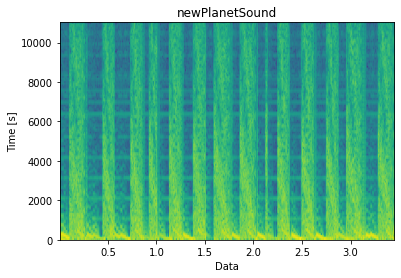

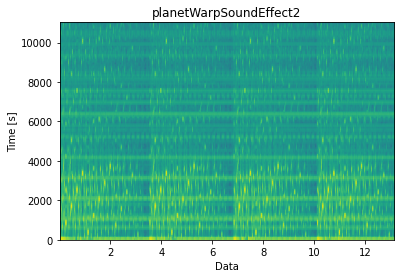

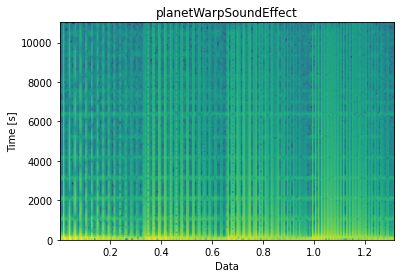

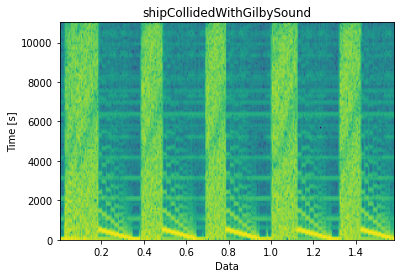

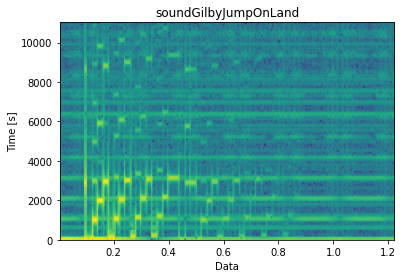

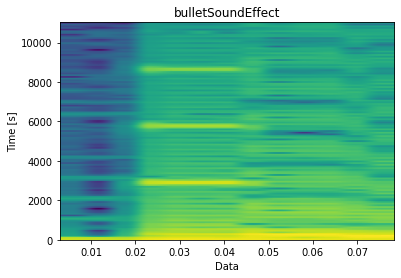

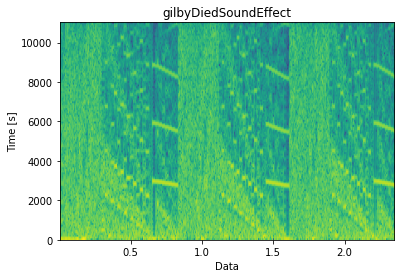

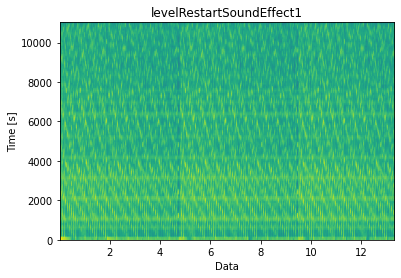

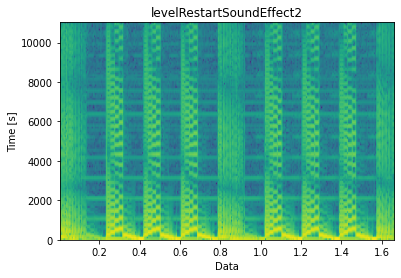

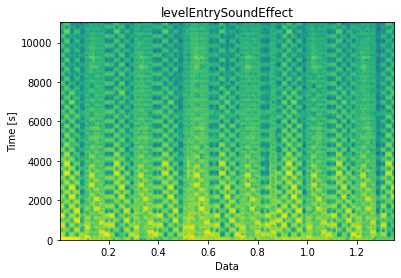

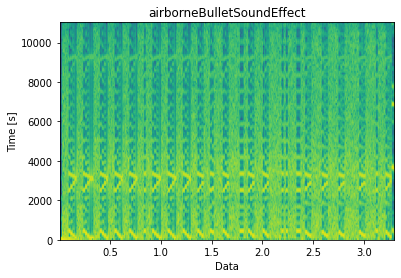

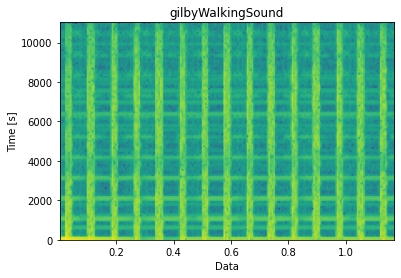

<ipython-input-151-8f08278fdf30>:7: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=0).
  powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(aud, Fs=Fs)


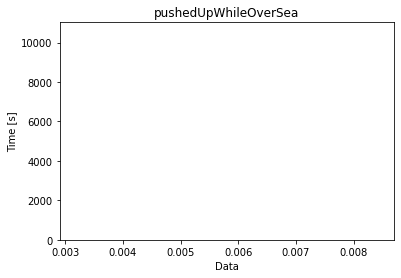

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

for wav_file in wav_files:
    Fs, aud = wavfile.read(wav_file)
    powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(aud, Fs=Fs)
    plt.title(wav_file.split('/')[1].split('.')[0])
    plt.xlabel("Data")
    plt.ylabel("Time [s]")
    plt.savefig(f"../src/{wav_file}-spec.png", bbox_inches="tight")
    plt.show()
    

## Matlib Plot

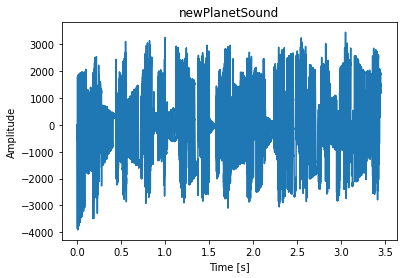

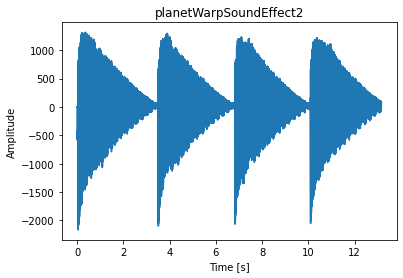

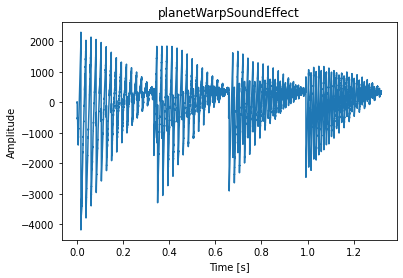

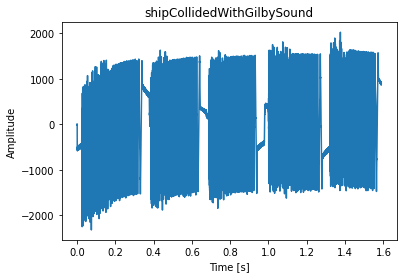

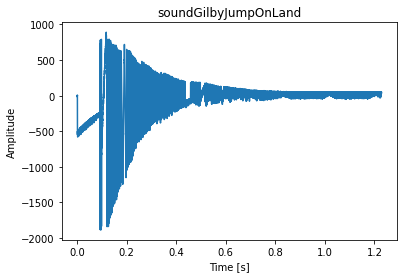

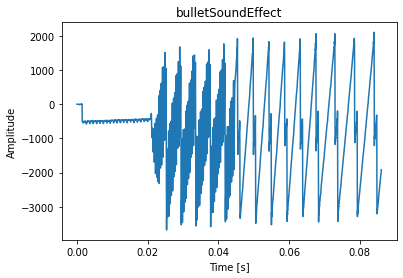

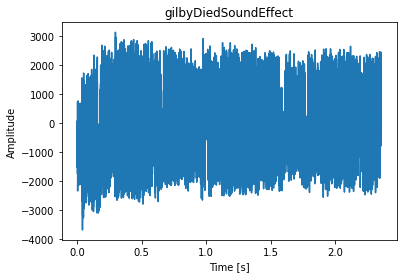

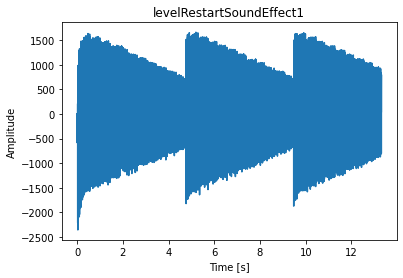

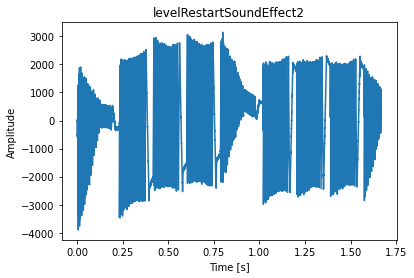

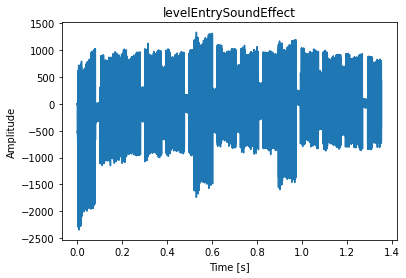

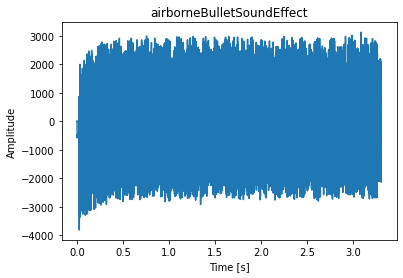

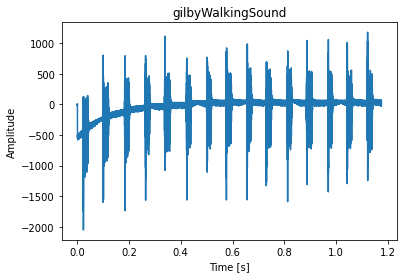

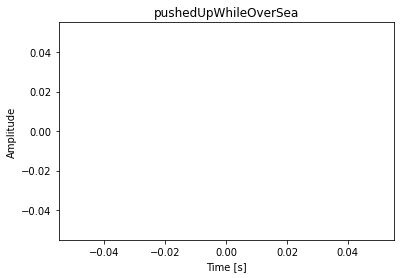

In [150]:
import os
import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt

for wavedata in wav_files:
    sampleRate, audioBuffer = scipy.io.wavfile.read(wavedata)
    duration = len(audioBuffer)/sampleRate
    time = np.arange(0,duration,1/sampleRate) #time vector

    plt.plot(time,audioBuffer)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(wavedata.split('/')[1].split('.')[0])
    plt.savefig(f"../src/{wavedata}-amp.png", bbox_inches="tight")
    plt.show()


## Leftover Stuff Not Used in the End

In [7]:
VOICE1_LO      = 0
VOICE1_HI      = 1
VOICE1_PLS_LO  = 2
VOICE1_PLS_HI  = 3
VOICE1_CTL     = 4
VOICE1_ATK_DEC = 5
VOICE1_SUS_REL = 6

VOICE2_LO      = 7
VOICE2_HI      = 8
VOICE2_PLS_LO  = 9
VOICE2_PLS_HI  = 10
VOICE2_CTL     = 11
VOICE2_ATK_DEC = 12
VOICE2_SUS_REL = 13

VOICE3_LO      = 14
VOICE3_HI      = 15
VOICE3_PLS_LO  = 16
VOICE3_PLS_HI  = 17
VOICE3_CTL     = 18
VOICE3_ATK_DEC = 19
VOICE3_SUS_REL = 20
FILTER_CUTOFF_LO  = 21
FILTER_CUTOFF_HI  = 22
FILTER_RES_CTL    = 23
FILTER_VOL     = 24

In [180]:
import wave, struct, random
import numpy as np
SAMPLE_RATE = 16.0 # hertz
FREQUENCY = 440.0 # hertz
STEREO = 2
MONO = 1
SID_CHANNELS = 3
SAMPLE_WIDTH = 2
amplitude = 6000

test_effect = [s[2] for s in samples if s[1] == 'planetWarpSoundEffect2']
sample_data = []
for t in test_effect:
    sample_data += [
                #int(t[VOICE1_HI] + t[VOICE1_LO], 16),
                int(t[VOICE2_HI] + t[VOICE2_LO], 16),
                int(t[VOICE3_HI] + t[VOICE3_LO], 16),
               ]

w = wave.open('test.wav', 'w')
w.setparams((STEREO, SAMPLE_WIDTH, SAMPLE_RATE, len(sample_data), 'NONE', None))

sine_wave = [np.sin(2 * np.pi * FREQUENCY * (x/SAMPLE_RATE))
             for x in sample_data]
for s in sample_data:
    w.writeframes(struct.pack('h', s))
w.close()    